In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install keras==2.12.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 10.4 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 2.12.0 which is incompatible.


In [ ]:
!pip install scikeras

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from scikeras.wrappers import KerasRegressor

from sklearn.model_selection import GridSearchCV

In [ ]:
center_id= 55
meal_id=1885

In [3]:
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')
meal=pd.read_csv('meal_info.csv')
train=train.merge(meal, on='meal_id')


In [4]:
center_id= 55
meal_id=1885

In [5]:
train_df=train[train["center_id"]==center_id]
train_df=train_df[train["meal_id"]==meal_id]

C:\Users\Rishabh\AppData\Local\Temp\ipykernel_16496\4218349882.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  train_df=train_df[train["meal_id"]==meal_id]


In [6]:
train_df.shape

(145, 11)

In [7]:
period = len(train_df)
train_df['Date'] = pd.date_range('2015-01-08', periods=period, freq='W')


In [49]:
train_df = train_df.set_index(['Date'])
train_df.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,category,cuisine
Date,,,,,,,,,,,
2015-01-11,1379560,1,55,1885,136.83,152.29,0,0,177,Beverages,Thai
2015-01-18,1018704,2,55,1885,135.83,152.29,0,0,323,Beverages,Thai
2015-01-25,1196273,3,55,1885,132.92,133.92,0,0,96,Beverages,Thai
2015-02-01,1116527,4,55,1885,135.86,134.86,0,0,163,Beverages,Thai
2015-02-08,1343872,5,55,1885,146.50,147.50,0,0,215,Beverages,Thai


In [50]:
lstm_data = train_df.drop(columns=['id','center_id','meal_id','category','cuisine','week'])


In [51]:
#perforing train test split in the dataset
test_split=round(len(lstm_data)*0.20)
df_for_training=lstm_data[:-test_split]
df_for_testing=lstm_data[-test_split:]
print(df_for_training.shape)
print(df_for_testing.shape)

(116, 5)
(29, 5)


In [52]:
scaler = MinMaxScaler(feature_range=(0,1))
df_for_training_scaled = scaler.fit_transform(df_for_training)
df_for_testing_scaled=scaler.transform(df_for_testing)
df_for_training_scaled

array([[0.40074135, 0.72444444, 0.        , 0.        , 0.16781293],
       [0.38014827, 0.72444444, 0.        , 0.        , 0.36863824],
       [0.32022241, 0.35333333, 0.        , 0.        , 0.05639615],
       [0.38076606, 0.37232323, 0.        , 0.        , 0.14855571],
       [0.59987644, 0.62767677, 0.        , 0.        , 0.22008253],
       [0.60049423, 0.60808081, 0.        , 0.        , 0.31636864],
       [0.57990115, 0.60808081, 0.        , 0.        , 0.12792297],
       [0.60049423, 0.58787879, 0.        , 0.        , 0.11004127],
       [0.35955519, 0.37171717, 0.        , 0.        , 0.1650619 ],
       [0.55992586, 0.54808081, 0.        , 0.        , 0.1650619 ],
       [0.60049423, 0.56767677, 0.        , 0.        , 0.25997249],
       [0.57990115, 0.60808081, 0.        , 0.        , 0.18569464],
       [0.57928336, 0.60747475, 0.        , 0.        , 0.01788171],
       [0.51997529, 0.50888889, 0.        , 0.        , 0.11004127],
       [0.        , 0.54929293, 0.

In [53]:
#splittting the data in X AND y
def createXY(dataset,n_past):
    dataX = []
    dataY = []
    for i in range(n_past, len(dataset)):
            dataX.append(dataset[i - n_past:i, 0:dataset.shape[1]])
            dataY.append(dataset[i,0])
    return np.array(dataX),np.array(dataY)
trainX,trainY=createXY(df_for_training_scaled,20)
testX,testY=createXY(df_for_testing_scaled,20)

In [54]:
print("trainX Shape-- ",trainX.shape)
print("trainY Shape-- ",trainY.shape)

trainX Shape--  (96, 20, 5)
trainY Shape--  (96,)


In [55]:
print("trainX Shape-- ",trainX.shape)
print("trainY Shape-- ",trainY.shape)

trainX Shape--  (96, 20, 5)
trainY Shape--  (96,)


In [16]:
print("trainX[0]-- \n",trainX[0])
print("trainY[0]-- ",trainY[0])

trainX[0]-- 
 [[0.40074135 0.72444444 0.         0.         0.16781293]
 [0.38014827 0.72444444 0.         0.         0.36863824]
 [0.32022241 0.35333333 0.         0.         0.05639615]
 [0.38076606 0.37232323 0.         0.         0.14855571]
 [0.59987644 0.62767677 0.         0.         0.22008253]
 [0.60049423 0.60808081 0.         0.         0.31636864]
 [0.57990115 0.60808081 0.         0.         0.12792297]
 [0.60049423 0.58787879 0.         0.         0.11004127]
 [0.35955519 0.37171717 0.         0.         0.1650619 ]
 [0.55992586 0.54808081 0.         0.         0.1650619 ]
 [0.60049423 0.56767677 0.         0.         0.25997249]
 [0.57990115 0.60808081 0.         0.         0.18569464]
 [0.57928336 0.60747475 0.         0.         0.01788171]
 [0.51997529 0.50888889 0.         0.         0.11004127]
 [0.         0.54929293 0.         0.         0.42778542]
 [0.         0.50888889 0.         0.         0.01650619]
 [0.10111203 0.54929293 0.         0.         0.2957359 ]


In [17]:
print(trainX.shape[1])
print(trainX.shape[2])

20
5


In [10]:
!pip install keras==2.12.0


  Using cached keras-2.12.0-py2.py3-none-any.whl (1.7 MB)
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-intel 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 2.12.0 which is incompatible.


In [11]:
!pip uninstall tensorflow
!pip install tensorflow==2.12.0


^C
^C


In [20]:
from keras.wrappers.scikit_learn import KerasRegressor


#applying model
def build_model(optimizer):
    grid_model = Sequential()
    grid_model.add(LSTM(50,return_sequences=True,input_shape=(20,5)))
    grid_model.add(LSTM(50))
    grid_model.add(Dropout(0.2))
    grid_model.add(Dense(1))
    grid_model.compile(loss = 'mse',optimizer = optimizer)
    return grid_model
grid_model = KerasRegressor(build_fn=build_model,verbose=1,validation_data=(testX,testY))
parameters = {'batch_size' : [2,4],
              'epochs' : [8,10],
              'optimizer' : ['adam','Adadelta'] }
grid_search  = GridSearchCV(estimator = grid_model,
                            param_grid = parameters,
                            cv = 2)

<ipython-input-20-35a9b2f3528a>:13: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  grid_model = KerasRegressor(build_fn=build_model,verbose=1,validation_data=(testX,testY))


In [21]:
grid_search = grid_search.fit(trainX,trainY)

Epoch 1/8
24/24 [==============================] - 5s 67ms/step - loss: 0.0818 - val_loss: 0.0326
Epoch 2/8
24/24 [==============================] - 0s 15ms/step - loss: 0.0239 - val_loss: 0.0168
Epoch 3/8
24/24 [==============================] - 0s 16ms/step - loss: 0.0241 - val_loss: 0.0028
Epoch 4/8
24/24 [==============================] - 0s 15ms/step - loss: 0.0224 - val_loss: 0.0036
Epoch 5/8
24/24 [==============================] - 0s 19ms/step - loss: 0.0189 - val_loss: 0.0137
Epoch 6/8
24/24 [==============================] - 1s 22ms/step - loss: 0.0202 - val_loss: 0.0112
Epoch 7/8
24/24 [==============================] - 1s 24ms/step - loss: 0.0193 - val_loss: 0.0030
Epoch 8/8
24/24 [==============================] - 0s 5ms/step - loss: 0.1178
Epoch 1/8
24/24 [==============================] - 4s 52ms/step - loss: 0.1259 - val_loss: 0.1422
Epoch 2/8
24/24 [==============================] - 0s 17ms/step - loss: 0.0943 - val_loss: 0.2942
Epoch 3/8
24/24 [=======================

In [23]:
grid_search.best_params_

{'batch_size': 4, 'epochs': 10, 'optimizer': 'adam'}

In [24]:
lstm_model=grid_search.best_estimator_.model

In [25]:
prediction=lstm_model.predict(testX)
print("prediction\n", prediction)
print("\nPrediction Shape-",prediction.shape)

1/1 [==============================] - 2s 2s/step
prediction
 [[0.41521138]
 [0.41795352]
 [0.4186302 ]
 [0.41486335]
 [0.41195768]
 [0.40926325]
 [0.4081251 ]
 [0.41019425]
 [0.41413212]]

Prediction Shape- (9, 1)


In [27]:
prediction_copies_array = np.repeat(prediction,5, axis=-1)



In [35]:
prediction_copies_array

array([[0.41521138, 0.41521138, 0.41521138, 0.41521138, 0.41521138],
       [0.41795352, 0.41795352, 0.41795352, 0.41795352, 0.41795352],
       [0.4186302 , 0.4186302 , 0.4186302 , 0.4186302 , 0.4186302 ],
       [0.41486335, 0.41486335, 0.41486335, 0.41486335, 0.41486335],
       [0.41195768, 0.41195768, 0.41195768, 0.41195768, 0.41195768],
       [0.40926325, 0.40926325, 0.40926325, 0.40926325, 0.40926325],
       [0.4081251 , 0.4081251 , 0.4081251 , 0.4081251 , 0.4081251 ],
       [0.41019425, 0.41019425, 0.41019425, 0.41019425, 0.41019425],
       [0.41413212, 0.41413212, 0.41413212, 0.41413212, 0.41413212]],
      dtype=float32)

In [28]:
prediction_copies_array.shape

(9, 5)

In [29]:
pred=scaler.inverse_transform(np.reshape(prediction_copies_array,(len(prediction),5)))[:,0]

In [30]:
original_copies_array = np.repeat(testY,5, axis=-1)
original=scaler.inverse_transform(np.reshape(original_copies_array,(len(testY),5)))[:,0]

In [31]:
print("Pred Values-- " ,pred)
print("\nOriginal Values-- " ,original)

Pred Values--  [137.53267 137.66582 137.69868 137.51576 137.37466 137.24382 137.18855
 137.28903 137.48026]

Original Values--  [153.29 155.23 150.35 151.35 150.35 148.47 150.35 150.35 156.23]


In [33]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(original, pred)

print("Mean Squared Error:", mse)

Mean Squared Error: 210.88754034566767


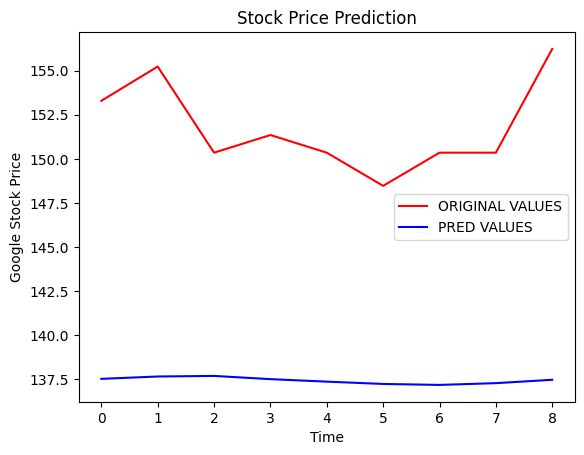

In [34]:
plt.plot(original, color = 'red', label = 'ORIGINAL VALUES')
plt.plot(pred, color = 'blue', label = 'PRED VALUES')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()
plt.show()